# Autoencoders (AE)

## What are Autoencoders?

Autoencoders are a type of neural network used to learn efficient representations of data in an unsupervised manner. They work by compressing input data into a lower-dimensional representation (encoding) and then reconstructing it back to the original form (decoding).

### Key Components:

1. **Encoder**: Compresses input data into a latent representation
2. **Latent Space**: The bottleneck layer containing the compressed representation
3. **Decoder**: Reconstructs the original input from the latent representation
4. **Reconstruction Loss**: Measures how well the output matches the input

### Applications:
- Dimensionality reduction
- Data denoising
- Anomaly detection
- Feature learning
- Data compression

In this tutorial, we'll build various types of autoencoders using the MNIST dataset.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Loading and Preprocessing MNIST Dataset

In [2]:
# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)

# Create data loaders
batch_size = 128
# Set num_workers=0 for compatibility across platforms
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [01:18<00:00, 127kB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 136kB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Training samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


## Visualizing Sample Images

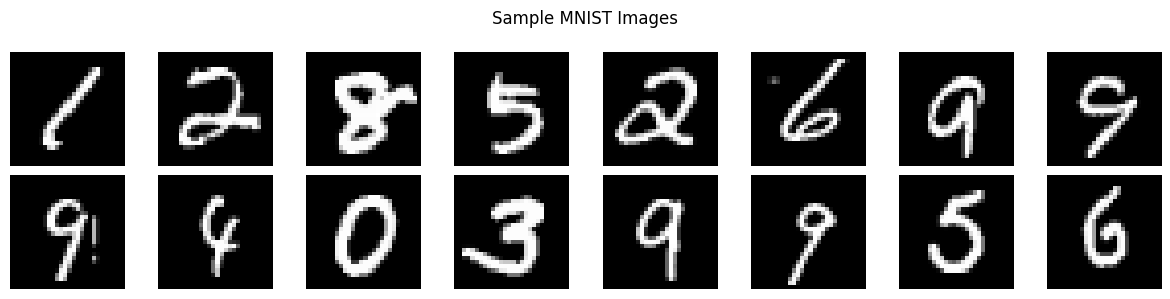

In [3]:
# Visualize some training images
def show_images(images, title='Sample Images', n_cols=8):
    """Display a grid of images"""
    n_images = len(images)
    n_rows = (n_images - 1) // n_cols + 1
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
    axes = axes.flatten() if n_rows > 1 else [axes]
    
    for i, (img, ax) in enumerate(zip(images, axes)):
        if isinstance(img, torch.Tensor):
            img = img.squeeze().cpu().numpy()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    
    # Hide remaining axes
    for i in range(len(images), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(images[:16], 'Sample MNIST Images')

## Building a Basic Autoencoder

Let's start with a simple fully-connected autoencoder

In [4]:
class BasicAutoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=32):
        super(BasicAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()  # To ensure output is in [0, 1]
        )
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

# Create model instance
basic_ae = BasicAutoencoder(latent_dim=32).to(device)
print(f'Model parameters: {sum(p.numel() for p in basic_ae.parameters()):,}')

Model parameters: 489,136


## Training the Basic Autoencoder

In [5]:
def train_autoencoder(model, train_loader, test_loader, epochs=10, lr=0.001):
    """Train an autoencoder model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
            # Flatten images
            data = data.view(data.size(0), -1).to(device)
            
            optimizer.zero_grad()
            recon, _ = model(data)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Evaluation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.view(data.size(0), -1).to(device)
                recon, _ = model(data)
                test_loss += criterion(recon, data).item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        print(f'Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses

# Train the model
print("Training Basic Autoencoder...")
basic_train_losses, basic_test_losses = train_autoencoder(basic_ae, train_loader, test_loader, epochs=10)

Training Basic Autoencoder...


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 262.07it/s]


Train Loss: 0.0615, Test Loss: 0.0410


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 270.89it/s]


Train Loss: 0.0328, Test Loss: 0.0280


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 270.89it/s]


Train Loss: 0.0261, Test Loss: 0.0238


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 270.18it/s]


Train Loss: 0.0224, Test Loss: 0.0206


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 270.89it/s]


Train Loss: 0.0198, Test Loss: 0.0184


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 270.50it/s]


Train Loss: 0.0179, Test Loss: 0.0168


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 267.84it/s]


Train Loss: 0.0167, Test Loss: 0.0160


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 269.51it/s]


Train Loss: 0.0157, Test Loss: 0.0150


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 271.32it/s]


Train Loss: 0.0149, Test Loss: 0.0144


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 271.04it/s]


Train Loss: 0.0142, Test Loss: 0.0137


## Visualizing Reconstructions

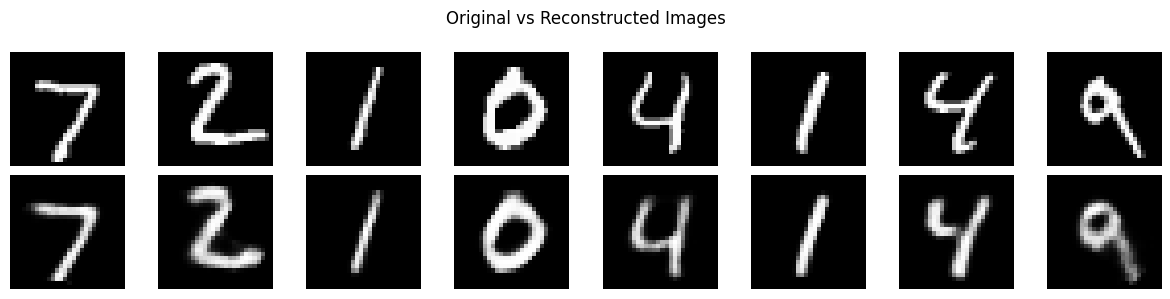

In [6]:
def visualize_reconstructions(model, test_loader, n_images=8):
    """Visualize original images and their reconstructions"""
    model.eval()
    
    # Get a batch of test images
    data, _ = next(iter(test_loader))
    data = data[:n_images]
    
    # Get reconstructions
    with torch.no_grad():
        flattened = data.view(data.size(0), -1).to(device)
        recon, _ = model(flattened)
        recon = recon.view(data.size()).cpu()
    
    # Plot
    fig, axes = plt.subplots(2, n_images, figsize=(n_images * 1.5, 3))
    
    for i in range(n_images):
        # Original
        axes[0, i].imshow(data[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Original', rotation=90, size='large')
        
        # Reconstruction
        axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_ylabel('Reconstructed', rotation=90, size='large')
    
    plt.suptitle('Original vs Reconstructed Images')
    plt.tight_layout()
    plt.show()

visualize_reconstructions(basic_ae, test_loader)

## Convolutional Autoencoder

For image data, convolutional autoencoders often work better than fully-connected ones

In [7]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7),  # 7x7 -> 1x1
            nn.ReLU()
        )
        
        # Latent space
        self.fc_encode = nn.Linear(64, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 64)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),  # 1x1 -> 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # 14x14 -> 28x28
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        return self.fc_encode(x)
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(x.size(0), 64, 1, 1)
        return self.decoder(x)
    
    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

# Create model instance
conv_ae = ConvAutoencoder(latent_dim=32).to(device)
print(f'Model parameters: {sum(p.numel() for p in conv_ae.parameters()):,}')

Model parameters: 214,561


In [8]:
# Train convolutional autoencoder
def train_conv_autoencoder(model, train_loader, test_loader, epochs=10, lr=0.001):
    """Train a convolutional autoencoder"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
            data = data.to(device)
            
            optimizer.zero_grad()
            recon, _ = model(data)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Evaluation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                recon, _ = model(data)
                test_loss += criterion(recon, data).item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        print(f'Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses

print("Training Convolutional Autoencoder...")
conv_train_losses, conv_test_losses = train_conv_autoencoder(conv_ae, train_loader, test_loader, epochs=10)

Training Convolutional Autoencoder...


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.34it/s]


Train Loss: 0.0712, Test Loss: 0.0473


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.38it/s]


Train Loss: 0.0319, Test Loss: 0.0235


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.30it/s]


Train Loss: 0.0206, Test Loss: 0.0171


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.22it/s]


Train Loss: 0.0157, Test Loss: 0.0139


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.23it/s]


Train Loss: 0.0134, Test Loss: 0.0124


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.21it/s]


Train Loss: 0.0117, Test Loss: 0.0106


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.22it/s]


Train Loss: 0.0104, Test Loss: 0.0099


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.26it/s]


Train Loss: 0.0098, Test Loss: 0.0094


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.90it/s]


Train Loss: 0.0093, Test Loss: 0.0088


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.22it/s]


Train Loss: 0.0089, Test Loss: 0.0087


## Comparing Architectures

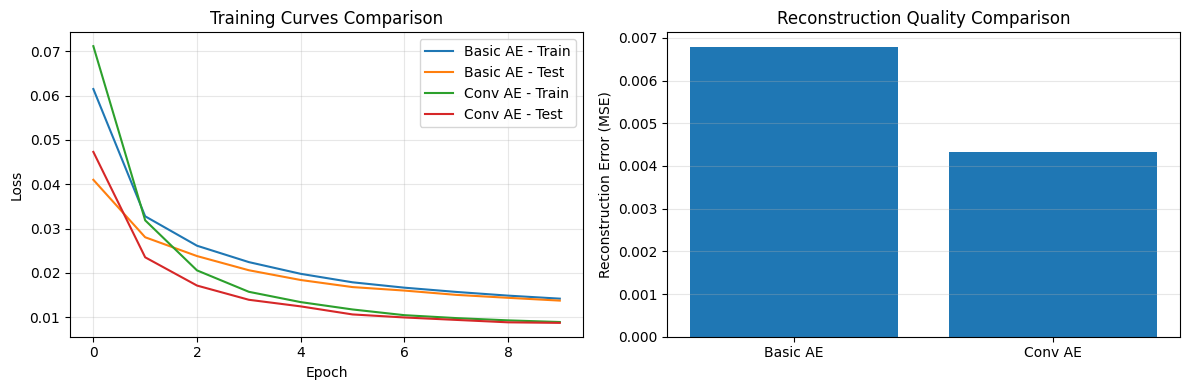

In [9]:
# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(basic_train_losses, label='Basic AE - Train')
plt.plot(basic_test_losses, label='Basic AE - Test')
plt.plot(conv_train_losses, label='Conv AE - Train')
plt.plot(conv_test_losses, label='Conv AE - Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Visualize reconstructions from both models
plt.subplot(1, 2, 2)
# Get sample data
data, _ = next(iter(test_loader))
sample = data[0:1].to(device)

# Basic AE reconstruction
with torch.no_grad():
    basic_recon, _ = basic_ae(sample.view(1, -1))
    basic_recon = basic_recon.view(1, 1, 28, 28)
    conv_recon, _ = conv_ae(sample)

# Calculate reconstruction errors
basic_error = F.mse_loss(basic_recon, sample).item()
conv_error = F.mse_loss(conv_recon, sample).item()

plt.bar(['Basic AE', 'Conv AE'], [basic_error, conv_error])
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Quality Comparison')
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Denoising Autoencoder

Denoising autoencoders learn to remove noise from corrupted inputs

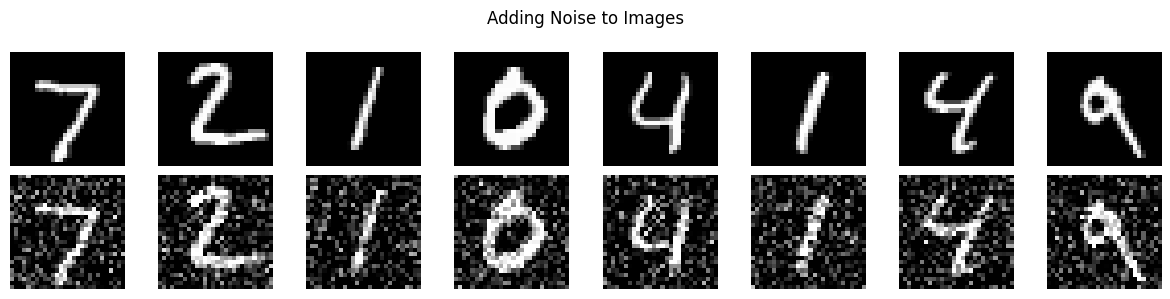

In [10]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, noise_factor=0.5):
        super(DenoisingAutoencoder, self).__init__()
        self.noise_factor = noise_factor
        
        # Use the same architecture as ConvAutoencoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
    
    def add_noise(self, x):
        """Add Gaussian noise to input"""
        noise = torch.randn_like(x) * self.noise_factor
        noisy = x + noise
        return torch.clamp(noisy, 0., 1.)
    
    def forward(self, x, add_noise=True):
        if add_noise and self.training:
            x = self.add_noise(x)
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Create denoising autoencoder
denoising_ae = DenoisingAutoencoder(noise_factor=0.3).to(device)

# Visualize noisy images
sample_images, _ = next(iter(test_loader))
noisy_images = denoising_ae.add_noise(sample_images[:8])

fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i in range(8):
    axes[0, i].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(noisy_images[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', rotation=90, size='large')
axes[1, 0].set_ylabel('Noisy', rotation=90, size='large')
plt.suptitle('Adding Noise to Images')
plt.tight_layout()
plt.show()

In [11]:
# Train denoising autoencoder
def train_denoising_ae(model, train_loader, test_loader, epochs=10, lr=0.001):
    """Train a denoising autoencoder"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
            data = data.to(device)
            
            # Add noise to input
            noisy_data = model.add_noise(data)
            
            optimizer.zero_grad()
            recon, _ = model(noisy_data, add_noise=False)
            loss = criterion(recon, data)  # Compare with clean data
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f'Train Loss: {avg_train_loss:.4f}')
    
    return train_losses

print("Training Denoising Autoencoder...")
denoising_losses = train_denoising_ae(denoising_ae, train_loader, test_loader, epochs=10)

Training Denoising Autoencoder...


Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.15it/s]


Train Loss: 0.0371


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 24.89it/s]


Train Loss: 0.0091


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.66it/s]


Train Loss: 0.0081


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.01it/s]


Train Loss: 0.0076


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.51it/s]


Train Loss: 0.0073


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 24.80it/s]


Train Loss: 0.0071


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 24.71it/s]


Train Loss: 0.0069


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.50it/s]


Train Loss: 0.0068


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.45it/s]


Train Loss: 0.0067


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 24.81it/s]

Train Loss: 0.0066


## Visualizing Denoising Results

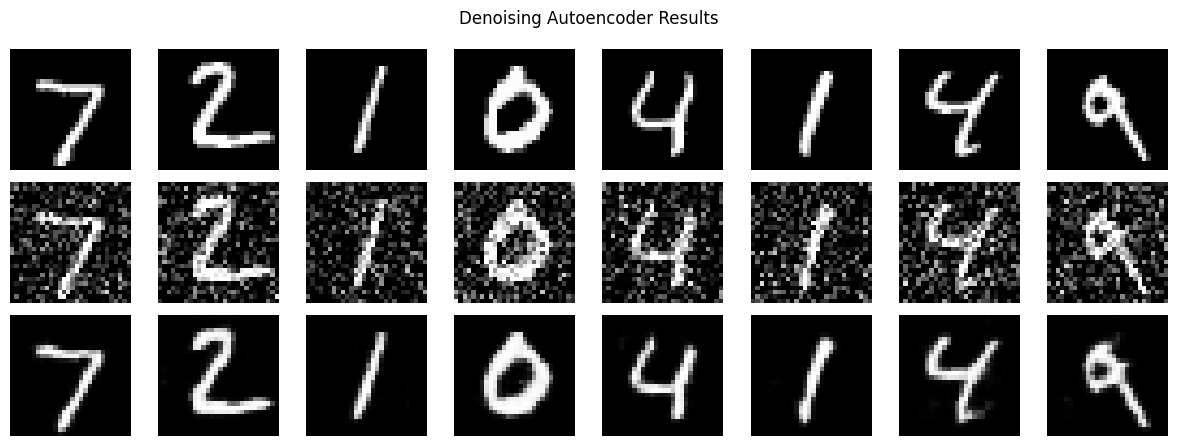

In [12]:
# Test denoising performance
denoising_ae.eval()
test_images, _ = next(iter(test_loader))
test_images = test_images[:8].to(device)

# Add noise
noisy_images = denoising_ae.add_noise(test_images)

# Denoise
with torch.no_grad():
    denoised_images, _ = denoising_ae(noisy_images, add_noise=False)

# Visualize results
fig, axes = plt.subplots(3, 8, figsize=(12, 4.5))
for i in range(8):
    # Original
    axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    
    # Noisy
    axes[1, i].imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')
    
    # Denoised
    axes[2, i].imshow(denoised_images[i].cpu().squeeze(), cmap='gray')
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Original', rotation=90, size='large')
axes[1, 0].set_ylabel('Noisy', rotation=90, size='large')
axes[2, 0].set_ylabel('Denoised', rotation=90, size='large')

plt.suptitle('Denoising Autoencoder Results')
plt.tight_layout()
plt.show()

## Sparse Autoencoder

Sparse autoencoders add a sparsity constraint to learn more meaningful features

In [13]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, sparsity_target=0.05):
        super(SparseAutoencoder, self).__init__()
        self.sparsity_target = sparsity_target
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        hidden = self.encoder(x)
        reconstructed = self.decoder(hidden)
        return reconstructed, hidden
    
    def kl_divergence(self, p, p_hat):
        """Calculate KL divergence for sparsity constraint"""
        return p * torch.log(p / p_hat) + (1 - p) * torch.log((1 - p) / (1 - p_hat))
    
    def sparse_loss(self, hidden, beta=0.01):
        """Calculate sparsity loss"""
        # Calculate average activation
        p_hat = torch.mean(hidden, dim=0)
        p = torch.ones_like(p_hat) * self.sparsity_target
        
        # KL divergence
        kl_div = self.kl_divergence(p, p_hat)
        return beta * torch.sum(kl_div)

# Create sparse autoencoder
sparse_ae = SparseAutoencoder(hidden_dim=128, sparsity_target=0.05).to(device)

# Training function with sparsity constraint
def train_sparse_ae(model, train_loader, epochs=10, lr=0.001, beta=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    mse_criterion = nn.MSELoss()
    
    losses = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
            data = data.view(data.size(0), -1).to(device)
            
            optimizer.zero_grad()
            recon, hidden = model(data)
            
            # Reconstruction loss + sparsity loss
            mse_loss = mse_criterion(recon, data)
            sparse_loss = model.sparse_loss(hidden, beta)
            loss = mse_loss + sparse_loss
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Loss: {avg_loss:.4f}')
    
    return losses

print("Training Sparse Autoencoder...")
sparse_losses = train_sparse_ae(sparse_ae, train_loader, epochs=10, beta=0.01)

Training Sparse Autoencoder...


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 288.84it/s]


Loss: inf


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 324.23it/s]


Loss: 0.0407


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 324.08it/s]


Loss: 0.0313


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 322.36it/s]


Loss: 0.0265


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 317.03it/s]


Loss: 0.0232


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 325.18it/s]


Loss: 0.0211


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 325.62it/s]


Loss: 0.0195


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 328.82it/s]


Loss: 0.0183


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 323.59it/s]


Loss: 0.0171


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 301.70it/s]

Loss: 0.0163


## Visualizing Learned Features

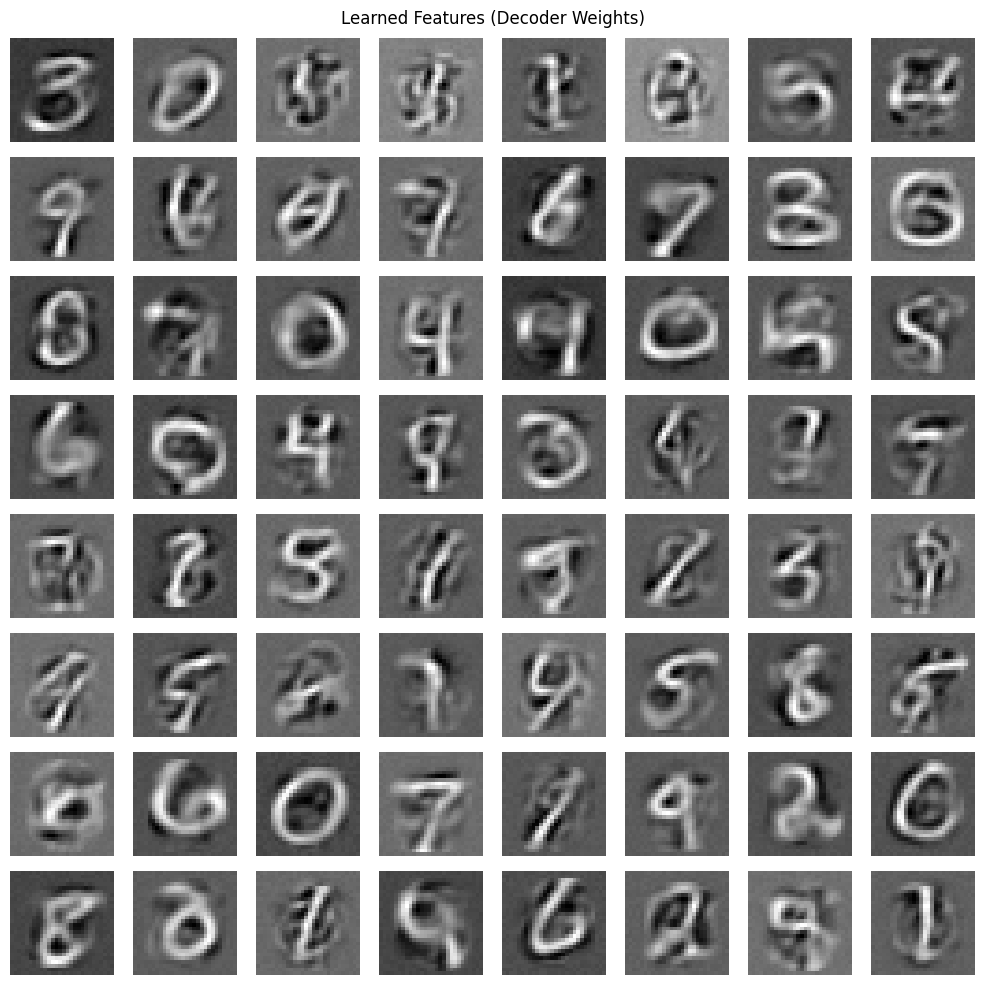

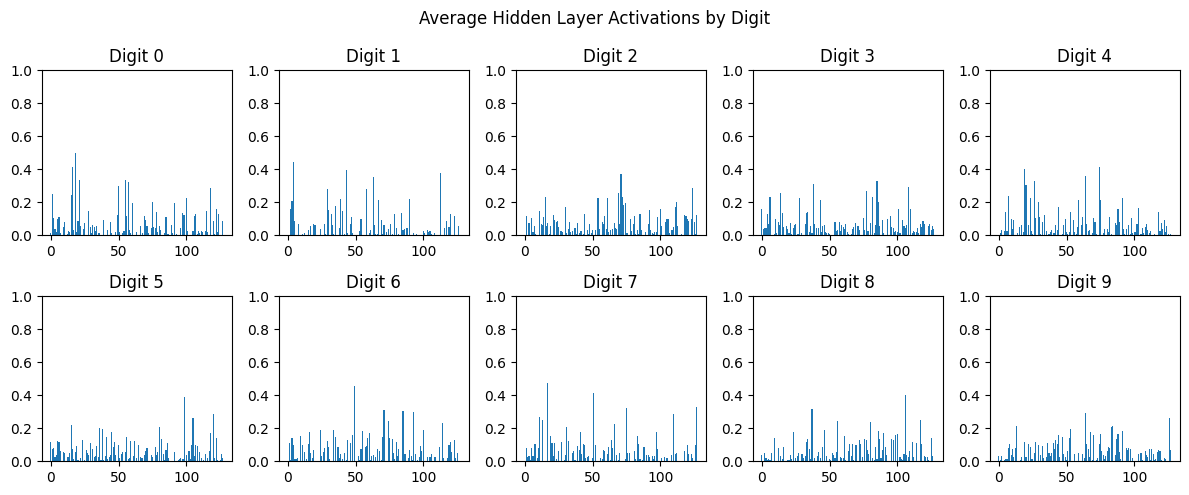

In [14]:
def visualize_learned_features(model, feature_type='decoder'):
    """Visualize what features the autoencoder has learned"""
    if feature_type == 'decoder':
        # Visualize decoder weights (what each hidden unit represents)
        weights = model.decoder[0].weight.data.cpu()
        n_features = min(64, weights.shape[1])  # Show max 64 features
        
        fig, axes = plt.subplots(8, 8, figsize=(10, 10))
        axes = axes.flatten()
        
        for i in range(n_features):
            feature = weights[:, i].view(28, 28)
            # Normalize for visualization
            feature = (feature - feature.min()) / (feature.max() - feature.min())
            axes[i].imshow(feature, cmap='gray')
            axes[i].axis('off')
        
        plt.suptitle('Learned Features (Decoder Weights)')
    
    elif feature_type == 'activations':
        # Visualize hidden layer activations for different digits
        model.eval()
        activations_by_digit = {i: [] for i in range(10)}
        
        with torch.no_grad():
            for data, labels in test_loader:
                data = data.view(data.size(0), -1).to(device)
                _, hidden = model(data)
                
                for i in range(len(labels)):
                    digit = labels[i].item()
                    if len(activations_by_digit[digit]) < 10:
                        activations_by_digit[digit].append(hidden[i].cpu())
        
        # Plot average activation patterns
        fig, axes = plt.subplots(2, 5, figsize=(12, 5))
        axes = axes.flatten()
        
        for digit in range(10):
            if activations_by_digit[digit]:
                avg_activation = torch.stack(activations_by_digit[digit]).mean(0)
                axes[digit].bar(range(len(avg_activation)), avg_activation.numpy())
                axes[digit].set_title(f'Digit {digit}')
                axes[digit].set_ylim(0, 1)
        
        plt.suptitle('Average Hidden Layer Activations by Digit')
    
    plt.tight_layout()
    plt.show()

# Visualize learned features
visualize_learned_features(sparse_ae, 'decoder')
visualize_learned_features(sparse_ae, 'activations')

## Latent Space Visualization

Let's visualize how different digits are encoded in the latent space

Basic Autoencoder Latent Space:


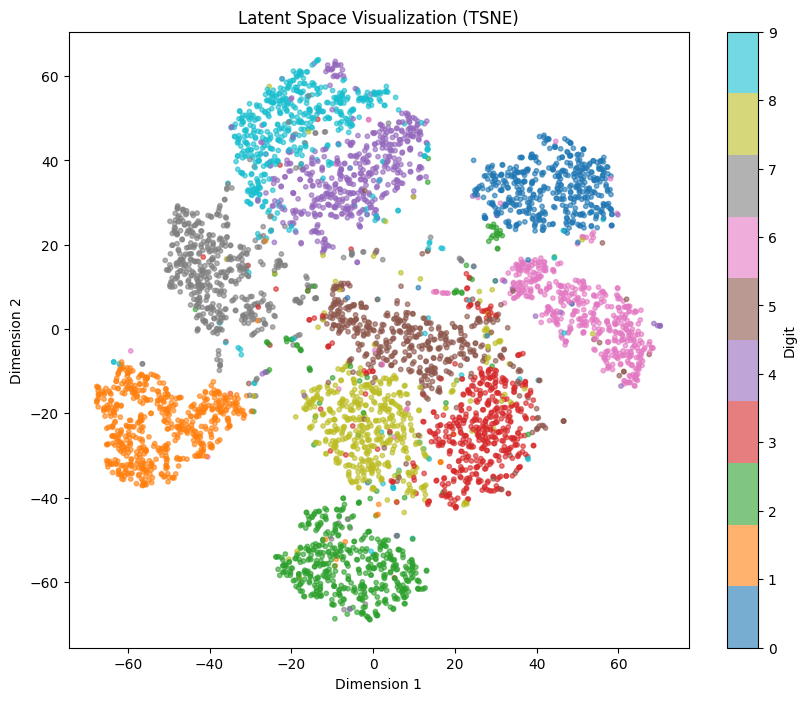


Convolutional Autoencoder Latent Space:


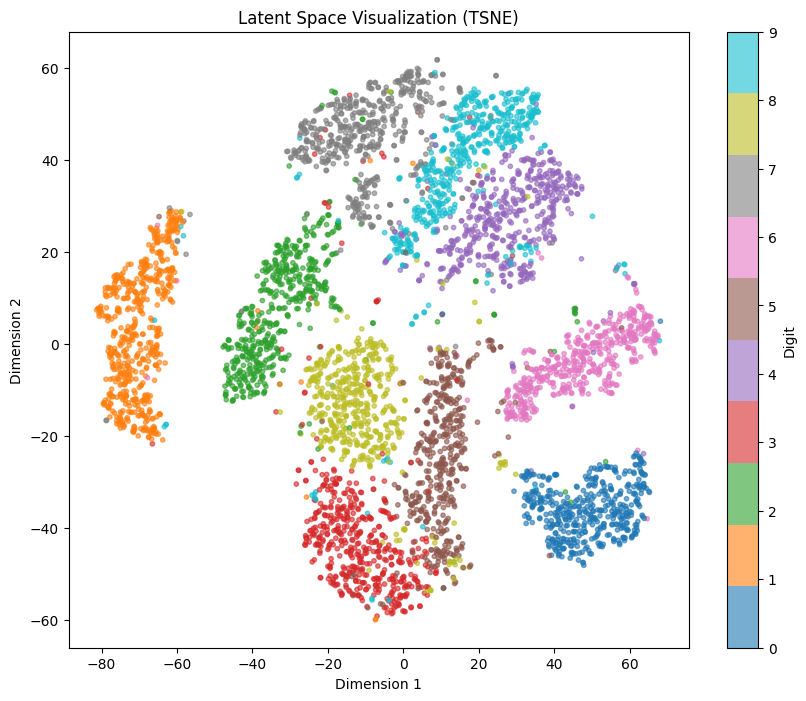

In [30]:
from sklearn.manifold import TSNE

def visualize_latent_space(model, test_loader, method='tsne'):
    """Visualize the latent space representations"""
    model.eval()
    latents = []
    labels = []
    
    # Better detection for convolutional models
    def is_conv_model(model):
        # Check if model has encoder with Conv2d layers
        if hasattr(model, 'encoder'):
            for module in model.encoder.modules():
                if isinstance(module, torch.nn.Conv2d):
                    return True
        # Check for direct conv attributes
        return any(hasattr(model, attr) for attr in ['conv1', 'conv2', 'convolution'])
    
    with torch.no_grad():
        for data, label in test_loader:
            if hasattr(model, 'encode'):
                # For models with separate encode method
                if len(data.shape) == 4 and is_conv_model(model):  # Conv models - keep 4D
                    z = model.encode(data.to(device))
                else:  # FC models - need to flatten
                    data = data.view(data.size(0), -1).to(device)
                    z = model.encode(data)
            else:
                # For other models
                data = data.view(data.size(0), -1).to(device)
                _, z = model(data)
            latents.append(z.cpu())
            labels.append(label)
            
    latents = torch.cat(latents, 0).numpy()
    labels = torch.cat(labels, 0).numpy()
    # Reduce to 2D for visualization
    if latents.shape[1] > 2:
        if method == 'tsne':
            tsne = TSNE(n_components=2, random_state=42)
            latents_2d = tsne.fit_transform(latents[:5000])  # Use subset for speed
            labels_subset = labels[:5000]
        else:  # PCA
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            latents_2d = pca.fit_transform(latents)
            labels_subset = labels
    else:
        latents_2d = latents
        labels_subset = labels
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                         c=labels_subset, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, label='Digit')
    plt.title(f'Latent Space Visualization ({method.upper()})')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

# Visualize latent spaces of different models
print("Basic Autoencoder Latent Space:")
visualize_latent_space(basic_ae, test_loader)

print("\nConvolutional Autoencoder Latent Space:")
visualize_latent_space(conv_ae, test_loader)

## Anomaly Detection with Autoencoders

Autoencoders can be used for anomaly detection by measuring reconstruction error

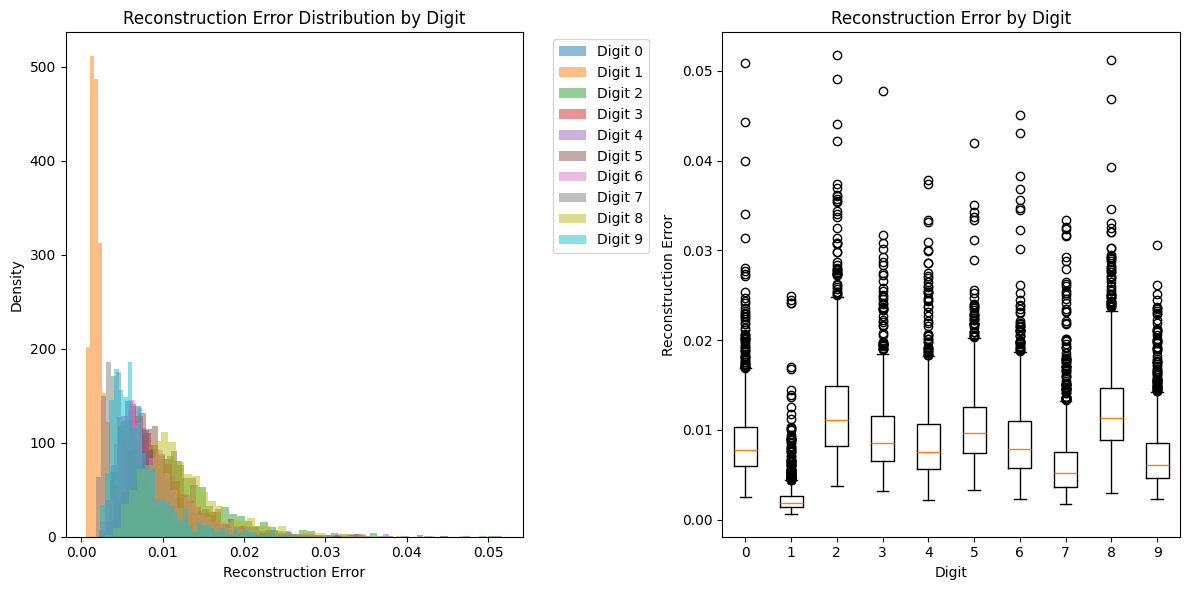

Digits with highest reconstruction errors: [0 6 8 3 2 0 8 2]


In [16]:
def compute_reconstruction_errors(model, data_loader):
    """Compute reconstruction errors for all samples"""
    model.eval()
    errors = []
    labels_list = []
    
    with torch.no_grad():
        for data, labels in data_loader:
            if len(data.shape) == 4:  # Conv model
                data = data.to(device)
                recon, _ = model(data)
            else:  # FC model
                data = data.view(data.size(0), -1).to(device)
                recon, _ = model(data)
                recon = recon.view(data.shape[0], 1, 28, 28)
                data = data.view(data.shape[0], 1, 28, 28)
            
            # Compute MSE for each sample
            mse = F.mse_loss(recon, data, reduction='none')
            mse = mse.view(mse.shape[0], -1).mean(dim=1)
            
            errors.extend(mse.cpu().numpy())
            labels_list.extend(labels.numpy())
    
    return np.array(errors), np.array(labels_list)

# Compute errors for test set
errors, labels = compute_reconstruction_errors(conv_ae, test_loader)

# Plot error distribution by digit
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for digit in range(10):
    digit_errors = errors[labels == digit]
    plt.hist(digit_errors, bins=50, alpha=0.5, label=f'Digit {digit}', density=True)
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Reconstruction Error Distribution by Digit')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1, 2, 2)
# Box plot of errors by digit
error_by_digit = [errors[labels == i] for i in range(10)]
plt.boxplot(error_by_digit, labels=range(10))
plt.xlabel('Digit')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error by Digit')

plt.tight_layout()
plt.show()

# Find samples with highest reconstruction error (potential anomalies)
top_errors_idx = np.argsort(errors)[-8:]
print(f"Digits with highest reconstruction errors: {labels[top_errors_idx]}")

## Exercises

Now it's your turn to experiment with autoencoders! Try these exercises:

### Exercise 1: Implement a Contractive Autoencoder
Implement an autoencoder with a contractive penalty that makes it robust to small input perturbations

In [ ]:
# Exercise 1: Contractive Autoencoder
class ContractiveAutoencoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=64):
        super(ContractiveAutoencoder, self).__init__()
        # TODO: Define encoder and decoder
        # Hint: You'll need to compute gradients of hidden layer w.r.t. input
        pass
    
    def forward(self, x):
        # TODO: Implement forward pass
        pass
    
    def contractive_loss(self, x, h, lambda_=0.01):
        """
        Compute contractive loss
        Args:
            x: input
            h: hidden representation
            lambda_: regularization strength
        """
        # TODO: Compute the Frobenius norm of the Jacobian
        pass

# Train your contractive autoencoder

### Exercise 2: Implement an Autoencoder for Different Data
Try using autoencoders on a different dataset (e.g., Fashion-MNIST, CIFAR-10)

In [ ]:
# Exercise 2: Autoencoder for Fashion-MNIST
# Load Fashion-MNIST dataset
# fashion_train = torchvision.datasets.FashionMNIST(root='./data', train=True,
#                                                   download=True, transform=transform)

# TODO: Create and train an autoencoder for Fashion-MNIST
# Consider what architecture might work best for clothing items

### Exercise 3: Interpolation in Latent Space
Implement latent space interpolation between two images

In [ ]:
# Exercise 3: Latent Space Interpolation
def interpolate_latent_space(model, img1, img2, n_steps=10):
    """
    Interpolate between two images in latent space
    
    Args:
        model: trained autoencoder
        img1, img2: input images
        n_steps: number of interpolation steps
    """
    model.eval()
    # TODO: Encode both images
    # TODO: Interpolate in latent space
    # TODO: Decode interpolated points
    # TODO: Visualize the interpolation
    pass

# Test interpolation between different digits

### Exercise 4: Implement a Stacked Autoencoder
Build a deep autoencoder by stacking multiple autoencoders

In [ ]:
# Exercise 4: Stacked Autoencoder
class StackedAutoencoder(nn.Module):
    def __init__(self, layer_sizes=[784, 500, 250, 100, 30]):
        super(StackedAutoencoder, self).__init__()
        # TODO: Build encoder and decoder with multiple layers
        # Consider using layer-wise pretraining
        pass
    
    def pretrain_layer(self, layer_idx, data_loader, epochs=5):
        """
        Pretrain a single layer as an autoencoder
        """
        # TODO: Implement layer-wise pretraining
        pass

# Implement and train your stacked autoencoder

## Summary

In this tutorial, we've covered:

1. **Basic Autoencoders**: Compress and reconstruct data
2. **Convolutional Autoencoders**: Better for image data
3. **Denoising Autoencoders**: Remove noise from corrupted inputs
4. **Sparse Autoencoders**: Learn sparse representations
5. **Applications**: Anomaly detection, feature learning, visualization

Key takeaways:
- Autoencoders learn compressed representations unsupervised
- The bottleneck forces the network to learn important features
- Different constraints lead to different types of representations
- Useful for dimensionality reduction, denoising, and anomaly detection

Autoencoders are foundational for understanding more complex generative models like VAEs!